In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf
import datetime

import warnings

import RECH_functions_2 as RECH

import pickle

In [12]:
act_func = RECH.relu

In [14]:
my_list = ["MMM",
"AXP",
"AMGN",
"AAPL",
"BA",
"CAT",
"CVX",
"CSCO",
"KO",
"DOW",
"GS",
"HD",
"HON",
"INTC",
"IBM",
"JNJ",
"JPM",
"MCD",
"MRK",
"MSFT",
"NKE",
"PG",
"CRM",
"TRV",
"UNH",
"VZ",
"V",
"WBA",
"WMT",
"DIS",
"^GSPC"]
my_list.remove("DOW") # dow joined in 2019
my_list.sort()

In [39]:

my_bounds = ((0.0001,5), (0.0001,1), (0.0001, 1), (0.0001, 1))
def con(t):
    return (-1)*(t[1] + 0.5 * t[2] + t[3]) + 0.999
cons = {'type':'ineq', 'fun': con}
par_names = ["omega", "alpha", "rho", "beta"]

df_pars = pd.DataFrame(columns = par_names, index = my_list)

forecast_all = pd.DataFrame()

mc_M = 5000

act_func = RECH.relu

for symbol in my_list:
    pd_this_share = pd.read_csv("data_ret.csv")
    is_list = [(pd_this_share.index[x] < datetime.date(2017, 1, 1)) for x in range(len(pd_this_share)) ]
    is_data = pd_this_share[is_list]
    is_data.drop(index=is_data.index[0], axis=0, inplace=True) # dropping the first value with NA in returns
    is_returns = is_data['log_ret * 100']
    #is_returns = is_data['log_ret']
    print("####################")
    print(is_returns.head(4))
    print("####################")
    # out of sample data is all the data from 01.01.2015
    os_list = [(pd_this_share.index[x] >= datetime.date(2017, 1, 1)) for x in range(len(pd_this_share)) ]
    os_data = pd_this_share[os_list]
    os_returns = os_data['log_ret * 100']
    #os_returns = os_data['log_ret']
    vP0 = (0.1, 0.1, 0.1, 0.8)
    my_bounds = ((0.0001,5), (0.0001,1), (0.00001, 1), (0.0001, 1))

    update_window = 20 # length of the updating window 20 -> monthly, 5 -> weekly
    sample_returns = is_returns # the sample returns serires keeps getting longer: after each iteration new informatuion is added
    os_decreasing = os_returns # out of sample returns, shrinking as sample increases
    forecasts_symbol = pd.DataFrame(index=os_data.index)
    horizons = (1, 5, 20)
    for p in range(len(horizons)):
        forecasts_symbol[symbol + f"_{horizons[p]}_h"] = np.zeros(len(os_returns))
    #print(symbol + f"_{horizons[p]}_h")
    print(forecasts_symbol.columns)
    for i in range(int(len(os_returns)/update_window)):
        if i == 0:
            # different starting values for optimisation as well as for forecasting in the first iteration
            res_gjr = opt.minimize(RECH.gjr_loglike, vP0, args = (act_func, sample_returns),
                          bounds = my_bounds,
                           #method = "Nelder-Mead",
                            method = "SLSQP",      
                          options = {"disp": True, "maxiter": 100000},
                            constraints = cons)
            # sample returns contain all information up to t = t
            # mc forecast function uses the lastest return as information
            
            for k in range(update_window):
                """for every time (t+1), (t+2), ... there are 3 forecasts made with respective information
                (t+1)-h1, (t+1)-h2, (t+1)-h3, (t+2)-h1, ... """
                for horizon in horizons:
                    fore = RECH.mc_gjr2(res_gjr.x, sample_returns[:-horizon], mc_M, horizon)
                    forecasts_symbol[symbol + f"_{horizon}_h"].iloc[i*update_window + k] = fore
                ### now for every k the sample grows by 1
                sample_returns = sample_returns.append(os_decreasing.head(1))
                os_decreasing = os_decreasing.tail(-1)
                
        else:
            sample_returns = sample_returns.tail(-update_window)
            new_bounds = my_bounds
            print(res_gjr.x)
            #print(new_bounds)
            res_gjr = opt.minimize(RECH.gjr_loglike, res_gjr.x, args = (act_func, sample_returns),
                          bounds = new_bounds,
                           #method = "Nelder-Mead",
                            method = "SLSQP",
                          options = {"disp": False, "maxiter": 10000},
                            constraints = cons)
            for k in range(update_window):
                """for every time (t+1), (t+2), ... there are 3 forecasts made with respective information
                (t+1)-h1, (t+1)-h2, (t+1)-h3, (t+2)-h1, ... """
                for horizon in horizons:
                    fore = RECH.mc_gjr2(res_gjr.x, sample_returns[:-horizon], mc_M, horizon)
                    forecasts_symbol[symbol + f"_{horizon}_h"].iloc[i*update_window + k] = fore
                ### now for every k the sample grows by 1
                sample_returns = sample_returns.append(os_decreasing.head(1))
                os_decreasing = os_decreasing.tail(-1)
                #print(f"in sample: {len(sample_returns)}, out of sample: {len(os_decreasing)}")
    forecast_all = pd.concat([forecast_all, forecasts_symbol], axis=1)
    df_pars.iloc[my_list.index(symbol)] = res_gjr.x        

[*********************100%***********************]  1 of 1 completed
####################
Date
2005-01-04 00:00:00-05:00    1.021786
2005-01-05 00:00:00-05:00    0.871977
2005-01-06 00:00:00-05:00    0.077505
2005-01-07 00:00:00-05:00    7.028254
Name: log_ret * 100, dtype: float64
####################
Index(['AAPL_1_h', 'AAPL_5_h', 'AAPL_20_h'], dtype='object')
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7065.807205373355
            Iterations: 21
            Function evaluations: 122
            Gradient evaluations: 20
[0.42033183 0.03823302 0.48643201 0.7088001 ]
[0.38730805 0.03978979 0.38914561 0.71495304]
[0.41360838 0.03451786 0.45333176 0.71102028]
[0.38729476 0.03492085 0.41214035 0.71759384]
[0.36018279 0.03558959 0.32971228 0.72379012]
[0.37094945 0.03541736 0.32708023 0.72032829]
[0.37760963 0.03614644 0.30352004 0.71753627]
[0.36715478 0.03877777 0.24281603 0.71580836]
[0.36684816 0.03497325 0.19425283 0.71836568]
[0.35703296

KeyboardInterrupt: 

In [ ]:
df_pars.to_csv("results/gjr_pars_7march.csv")
forecast_all.to_csv("results/gjr_forecasts_5march.csv")

In [30]:
df_pars

,omega,alpha,rho,beta
MSFT,0.384235,0.104089,0.00001,0.629453
WBA,1.64928,0.101905,0.00001,0.209557
AAPL,0.290871,0.030262,0.406885,0.730687
DIS,0.289154,0.069463,0.209461,0.664092


<AxesSubplot:xlabel='Date'>

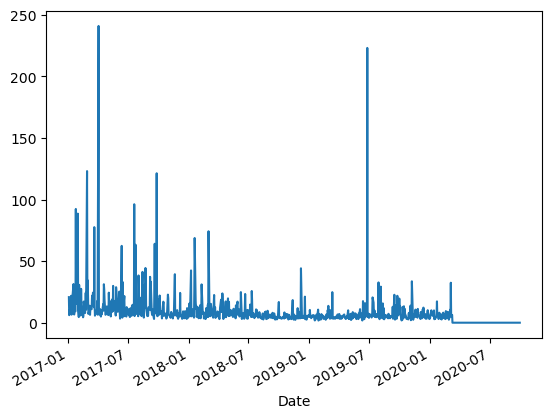

In [36]:
forecast_all["AAPL_20_h"].plot()